# Árboles de Decisiones
____________


In [69]:
import math
import warnings

# Desactivar advertencias de FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

### Carga de datos

#### Importation de las librerias basicas

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import treelib

In [71]:
# Carga el data set en una variable
prestamos = pd.read_excel('../datos/prestamos_bancarios_alemanes_1994.xls')

#### Exproracion de los datos

In [72]:
prestamos.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1.0,18.0,4.0,2.0,1049.0,1.0,2.0,4.0,2.0,...,4.0,2.0,21.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0
1,1,1.0,9.0,4.0,0.0,2799.0,1.0,3.0,2.0,3.0,...,2.0,1.0,36.0,3.0,1.0,2.0,3.0,2.0,1.0,1.0
2,1,2.0,12.0,2.0,9.0,841.0,2.0,4.0,2.0,2.0,...,4.0,1.0,23.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0
3,1,1.0,12.0,4.0,0.0,2122.0,1.0,3.0,3.0,3.0,...,2.0,1.0,39.0,3.0,1.0,2.0,2.0,2.0,1.0,2.0
4,1,1.0,12.0,4.0,0.0,2171.0,1.0,3.0,4.0,3.0,...,4.0,2.0,38.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0


In [73]:
# Obtiene información de las filas y las columnas
prestamos.info()
total_registro = prestamos.shape[0]
print(f'Total de registro en el dataset: {total_registro}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Creditability                      1001 non-null   int64  
 1   Account Balance                    1000 non-null   float64
 2   Duration of Credit (month)         1000 non-null   float64
 3   Payment Status of Previous Credit  1000 non-null   float64
 4   Purpose                            1000 non-null   float64
 5   Credit Amount                      1000 non-null   float64
 6   Value Savings/Stocks               1000 non-null   float64
 7   Length of current employment       1000 non-null   float64
 8   Instalment per cent                1000 non-null   float64
 9   Sex & Marital Status               1000 non-null   float64
 10  Guarantors                         1000 non-null   float64
 11  Duration in Current address        1000 non-null   float

In [74]:
prestamos.describe()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
count,1001.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,...,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.398601,2.577000,20.903000,2.54500,2.828000,3271.24800,2.105000,3.384000,2.973000,2.68200,...,2.845000,2.358000,35.54200,2.675000,1.928000,1.407000,2.904000,1.155000,1.404000,1.037000
std,22.107509,1.257638,12.058814,1.08312,2.744439,2822.75176,1.580023,1.208306,1.118715,0.70808,...,1.103718,1.050209,11.35267,0.705601,0.530186,0.577654,0.653614,0.362086,0.490943,0.188856
min,0.000000,1.000000,4.000000,0.00000,0.000000,250.00000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,19.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1.000000,12.000000,2.00000,1.000000,1365.50000,1.000000,3.000000,2.000000,2.00000,...,2.000000,1.000000,27.00000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
50%,1.000000,2.000000,18.000000,2.00000,2.000000,2319.50000,1.000000,3.000000,3.000000,3.00000,...,3.000000,2.000000,33.00000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
75%,1.000000,4.000000,24.000000,4.00000,3.000000,3972.25000,3.000000,5.000000,4.000000,3.00000,...,4.000000,3.000000,42.00000,3.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000
max,700.000000,4.000000,72.000000,4.00000,10.000000,18424.00000,5.000000,5.000000,4.000000,4.00000,...,4.000000,4.000000,75.00000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000


In [75]:
prestamos.isnull().sum()

Creditability                        0
Account Balance                      1
Duration of Credit (month)           1
Payment Status of Previous Credit    1
Purpose                              1
Credit Amount                        1
Value Savings/Stocks                 1
Length of current employment         1
Instalment per cent                  1
Sex & Marital Status                 1
Guarantors                           1
Duration in Current address          1
Most valuable available asset        1
Age (years)                          1
Concurrent Credits                   1
Type of apartment                    1
No of Credits at this Bank           1
Occupation                           1
No of dependents                     1
Telephone                            1
Foreign Worker                       1
dtype: int64

### Seleccion de las variables con las que vamos a trabajar

In [76]:
categorias_elegidas = ["Account Balance","Duration of Credit (month)", "Payment Status of Previous Credit", "Purpose", "Sex & Marital Status"]
prestamos = prestamos[['Creditability'] + categorias_elegidas].copy()

### Limpieza de datos
* Se eliminan las filas con valores __NULL__
* Eliminar los duplicados

In [77]:
prestamos = prestamos.dropna()
prestamos.isnull().sum()

Creditability                        0
Account Balance                      0
Duration of Credit (month)           0
Payment Status of Previous Credit    0
Purpose                              0
Sex & Marital Status                 0
dtype: int64

In [78]:
# Elimina los datos duplicados
prestamos.drop_duplicates(inplace=True)
# Verificar las datos duplicados
cantidad_duplicados = prestamos.duplicated().sum()
print(f'Total de filas duplicadas: {cantidad_duplicados}')

Total de filas duplicadas: 0


In [79]:
prestamos.info()
total_registros = prestamos.shape[0]
print(f'Total de registro después de la limpeza: {total_registros}')

<class 'pandas.core.frame.DataFrame'>
Index: 756 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Creditability                      756 non-null    int64  
 1   Account Balance                    756 non-null    float64
 2   Duration of Credit (month)         756 non-null    float64
 3   Payment Status of Previous Credit  756 non-null    float64
 4   Purpose                            756 non-null    float64
 5   Sex & Marital Status               756 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 41.3 KB
Total de registro después de la limpeza: 756


### Matriz de correlacion

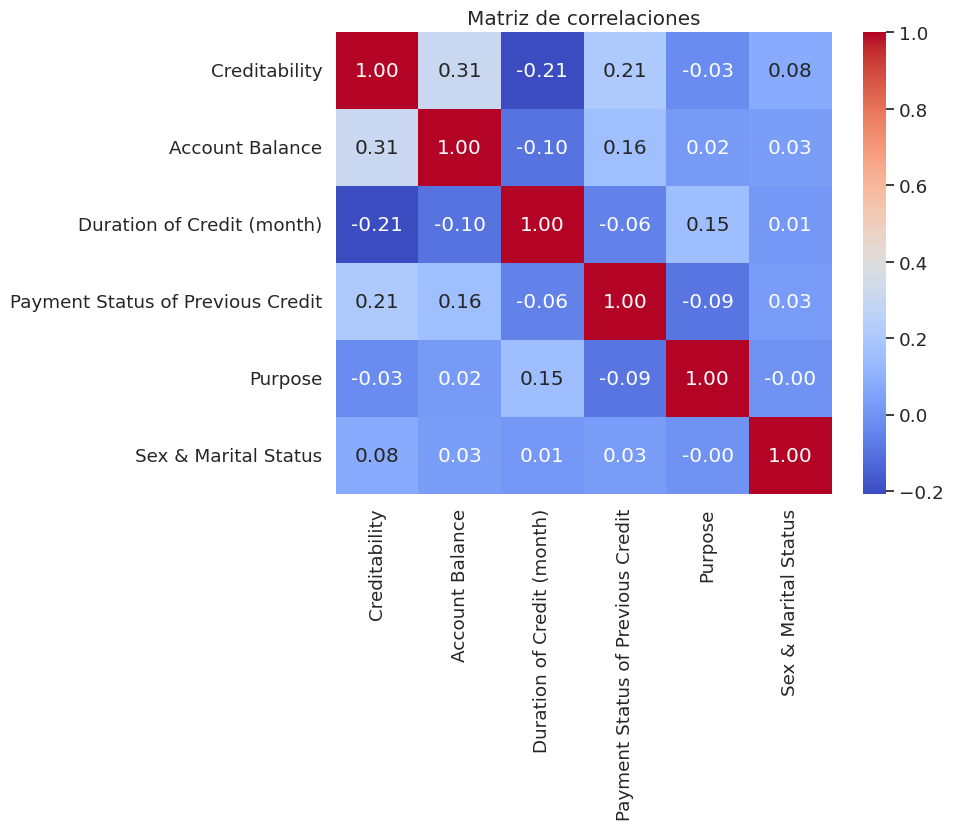

In [80]:
# Se crea la matriz
matriz = prestamos.corr()

# Gráfico de la matriz
# tamaño de la figura
plt.figure(figsize=(8,6))

# Crea el mapa de calor
sns.heatmap(matriz,annot=True, cmap='coolwarm',fmt='.2f')

# Agregar Titulo y etiquetas
plt.title('Matriz de correlaciones')
plt.show()

## Cuantificar la variables continuas
1. Duration of credit month


In [81]:
# Estadisticas descriptivas de las variables continuas

estadistica_duration = prestamos['Duration of Credit (month)'].describe()

print(estadistica_duration)

count    756.000000
mean      21.425926
std       12.665166
min        4.000000
25%       12.000000
50%       18.000000
75%       27.000000
max       72.000000
Name: Duration of Credit (month), dtype: float64


In [82]:
import pandas as pd

def cuantificar_variable(dataframe, nombreVar, num_grupos=4):
    # Ordenar el DataFrame según la columna a cuantificar
    dataframe = dataframe.sort_values(by=nombreVar, ascending=True).reset_index(drop=True)
    n = len(dataframe)
    
    # Calcular los límites de los cuartiles
    cuartiles = [dataframe[nombreVar].quantile(i / num_grupos) for i in range(1, num_grupos)]
    
    for i in range(len(dataframe)):
        for j, limite in enumerate(cuartiles):
            if dataframe.at[i, nombreVar] <= limite:
                dataframe.at[i, nombreVar] = j
                break
        else:
            dataframe.at[i, nombreVar] = num_grupos - 1

    return dataframe

prestamos = cuantificar_variable(prestamos, 'Duration of Credit (month)',num_grupos=4)


#### Diagramas de cajas de las variables
+ Creditability
+ Account Balance  
+ Duration of Credit (month)  
+ Payment Status of Previous Credit
+ Purpose 
+ Sex & Marital Status 

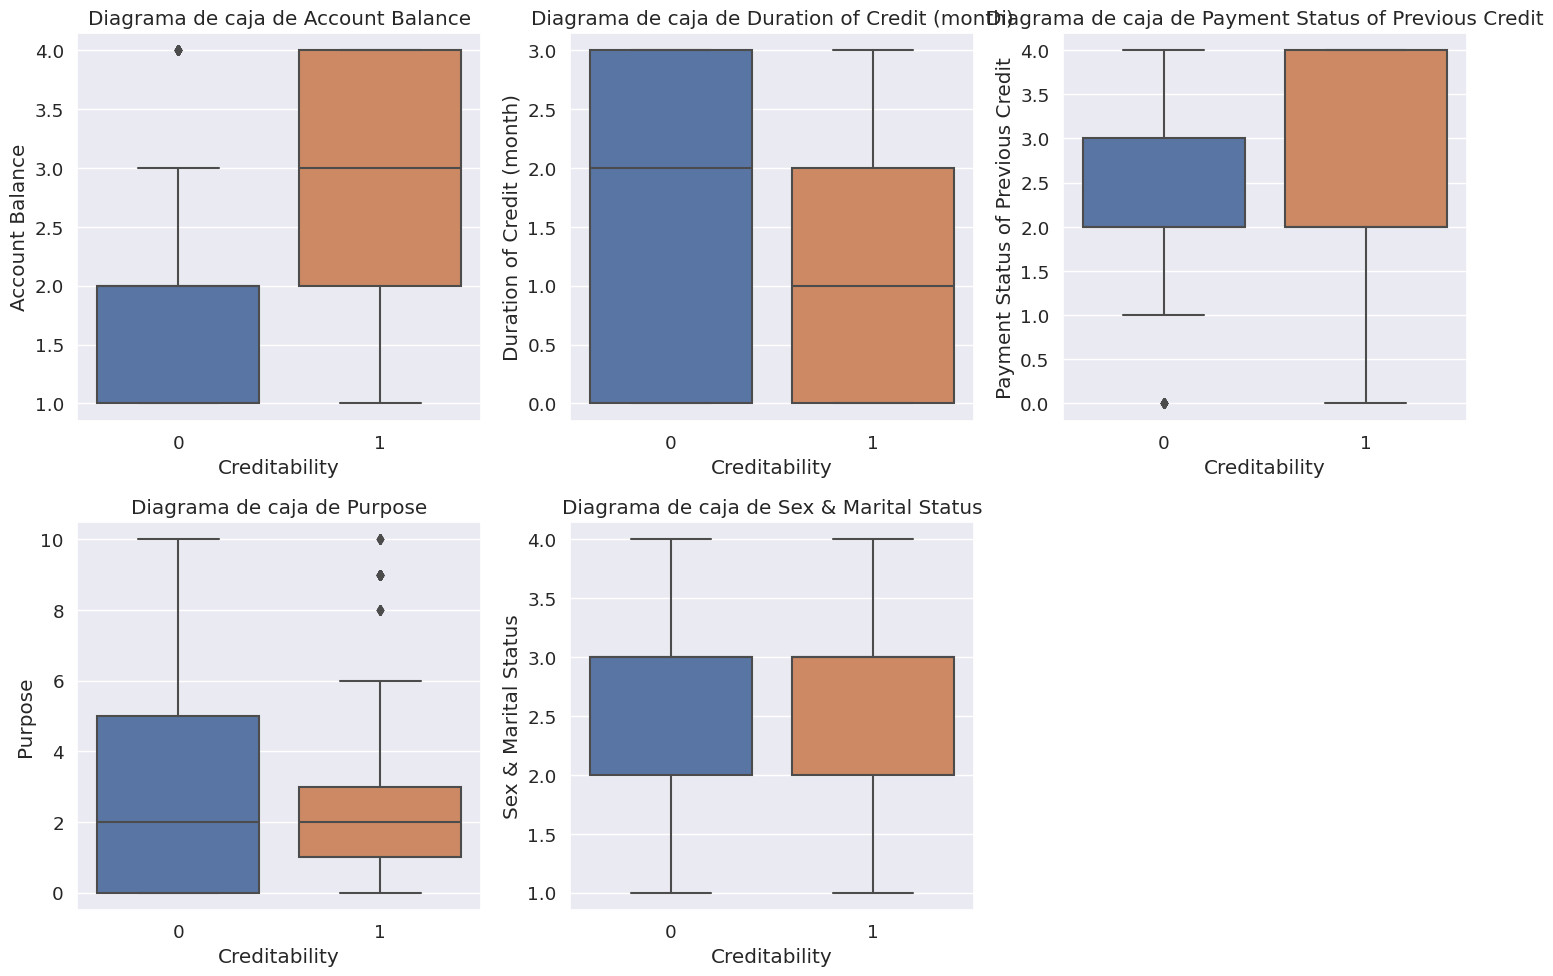

In [83]:
# Creamos la figura
plt.figure(figsize=(15,10))

# Iteramos sobres la categorias elegidas y creamos un diagrama para cada una
for i, variable in enumerate(categorias_elegidas,1):
    plt.subplot(2,3,i) # Crea una cuadricula de 2x3
    sns.boxplot(data=prestamos, y=variable, x='Creditability')
    plt.title(f'Diagrama de caja de {variable}')
# Ajustar los graficos
plt.tight_layout()
plt.show()

## Division de los datos de entrenamientos, prueba y validacion
* Conjunto de entrenamientos = 60%
* Conjunto de validacion = 20%
* Conjunto de test = 20%

In [84]:
# Separa las características (X) y la variable objetivo (y)
X = prestamos[['Account Balance', 'Duration of Credit (month)', 'Payment Status of Previous Credit', 'Purpose', 'Sex & Marital Status']]
y = prestamos['Creditability']


In [85]:
import numpy as np

np.random.seed(42)

limite = int(len(prestamos) * 0.7) # en donde partimos los datos
datos_entrenamiento = prestamos[:limite]
datos_prueba = prestamos[limite:]


# Define las proporciones para la division del los conjuntos
ratios = [0.6,0.2,0.2] # 70% Entrenamiento, 20% validacion, 20% testeo

#Calcular el tamaño de cada conjunto
total_samples = len(X)
sizes = [int(r * total_samples) for r in ratios]

# General indices aleatorios
random_indices = np.random.permutation(total_samples)

#Division de los conjuntos
X_train = X.iloc[random_indices[:sizes[0]]]
X_val = X.iloc[random_indices[sizes[0]: sizes[0] + sizes[1]]]
X_test = X.iloc[random_indices[sizes[0] + sizes[1]:]]

y_train = y.iloc[random_indices[:sizes[0]]]
y_val = y.iloc[random_indices[sizes[0]:sizes[0] + sizes[1]]]
y_test = y.iloc[random_indices[sizes[0] + sizes[1]:]]

print("Cantidad de datos en el conjunto de entrenamiento:", X_train.shape[0])
print("Cantidad de datos en el conjunto de validación:", X_val.shape[0])
print("Cantidad de datos en el conjunto de prueba:", X_test.shape[0])


Cantidad de datos en el conjunto de entrenamiento: 453
Cantidad de datos en el conjunto de validación: 151
Cantidad de datos en el conjunto de prueba: 152


# Creacion del modelo - ___ÁRBOL DE DECISION___

### Calcular al Entropía de Shannon para todo el conjunto de datos
 $$\large H(S) = -p(S_{i'})\log_2(p(S_{i'})) - p(No)\log_2(p(No))$$ 


In [86]:
def entropia_shannon(data, target_atributo):
    entropia = 0
    total_records = len(data)
    
    unique_classes = data[target_atributo].unique()
    
    for unique_class in unique_classes:
        class_records = data[data[target_atributo] == unique_class]
        class_count = len(class_records)
        probabilidad = class_count / total_records
        entropia -= round(probabilidad * math.log2(probabilidad),4)
    return entropia

entropia = entropia_shannon(prestamos, 'Creditability')
print(f' Calculo de la entropia del todo el conjunto de datos: {entropia}')

 Calculo de la entropia del todo el conjunto de datos: 0.9235


### Calculo de ___Ganancia___

$$\large G(S,A) = H(S) - ∑_{v\in A} \frac{|S_v|} ⋅ H(S_v)$$

In [87]:
def calculo_ganancia(data,target_atributo, atributo):
    # Calculamos la entropia inicial
    entropia_s = entropia_shannon(data,target_atributo)
    
    # Obtener los valores unico del atributo
    valores_unicos = data[atributo].unique()
    
    # Calculo de la suma ponderada de las entropias despues de la division
    suma_entropia = 0
    total_registro = len(data)
    
    for value in valores_unicos:
        subset = data[data[atributo] == value]
        subset_size = len(subset)
        entropia_subset = entropia_shannon(subset,target_atributo)
        suma_entropia += (subset_size / total_registro) * entropia_subset
        
    # Calculo de la ganancia
    informacion_ganancia = entropia_s - suma_entropia
    return informacion_ganancia

# Calculamos la ganancia para todos los atributos
for column in prestamos.columns[1:]: # Se excluye el atributo 'Creditability'
    informacion_ganancia = calculo_ganancia(prestamos,'Creditability',column)
    print(f'Ganancia de la informacion para la {column} : {informacion_ganancia}')

Ganancia de la informacion para la Account Balance : 0.07218531746031731
Ganancia de la informacion para la Duration of Credit (month) : 0.02333584656084664
Ganancia de la informacion para la Payment Status of Previous Credit : 0.03530965608465597
Ganancia de la informacion para la Purpose : 0.020259523809523783
Ganancia de la informacion para la Sex & Marital Status : 0.004271428571428593


## Seleccion de la Mejor Atributo


In [88]:
def buscar_mayor_ganancia(dataset, target_atributo):
    atributos = dataset.columns[1:]

    # Inicia las variables
    mejor_carateristica = None
    mejor_ganancia = -1  # inicia en valor muy bajo

    # Calcula la ganancia de informacion para cada atributo y encuentra al mejor
    for atributo in atributos:
        ganancia = calculo_ganancia(dataset, target_atributo, atributo)
    #    print(f'Ganancia de informacion para {atributo}: {ganancia}')

        if ganancia > mejor_ganancia:
            mejor_ganancia = ganancia
            mejor_carateristica = atributo

    return mejor_carateristica

# GENERAR ARBOL

## 

In [89]:
class Prediction(object):
        def __init__(self, prediction):
            self.prediction = prediction

"""
GENERA SUBARBOL DE UN ATRIBUTO

dataset -> pd array, to be cropped
target_atributo -> atributo el cual queremos predecir
atributo -> atributo a expandir
atributos_restantes -> numero de atributos que no se van a usar, 0 utiliza todos los atributos, 1 utiliza todos los atributos menos 1.... tiene que ser minimo 1
:return subarbol (Tree) y DataFrame reducido (sin el atributo)
"""
def generar_subarbol(dataset: pd.DataFrame, target_atributo, atributo, atributos_restantes=1):
    #print(atributo)
    clases_restantes = list(dataset.columns)
    clases_restantes.remove(target_atributo)
    subarbol = treelib.Tree()
    nodo_atributo = subarbol.create_node(atributo,data=Prediction("?"))

    # creamos hijos para las opciones
    try:
        unique_classes = dataset[atributo].unique()
    except Exception as ex:
        #print(ex)
        if len(dataset[dataset[target_atributo] == 1]) > len(dataset[dataset[target_atributo] == 0]):
            nodo_atributo.data.prediction = "1"
        else:
            nodo_atributo.data.prediction = "0"
        return subarbol
    for c in unique_classes:
    #    print("\t ", c)
        arbol_hijo = None
        prediccion = "?"
        # calcular si resultado es positivo o negativo

        # conseguimos dataframe despues de realizar movimiento
        dataframe_parcial = dataset[dataset[atributo] == c]

        # numero de 1 en dataframe parcial
        nPositivos = len(dataframe_parcial[dataframe_parcial[target_atributo] == 1])

        # numero de 0 en dataframe parcial
        nNegativos = len(dataframe_parcial[dataframe_parcial[target_atributo] == 0])


        if len(dataframe_parcial) == nPositivos:
            prediccion = "1"
        elif len(dataframe_parcial) == nNegativos:
            prediccion = "0"
        # condiciones para parar
        elif len(clases_restantes) <= atributos_restantes:
            if nNegativos > nPositivos:
                prediccion = "0"
            else:
                prediccion = "1"
        else:
            prediccion = "?" # habrá que desarrollar el árbol
            arbol_hijo = generar_subarbol(dataframe_parcial.drop(columns=atributo), target_atributo, buscar_mayor_ganancia(dataframe_parcial, target_atributo))
            if arbol_hijo.get_node(arbol_hijo.root).data.prediction != "?":
                prediccion = arbol_hijo.get_node(arbol_hijo.root).data.prediction
                arbol_hijo = None

        nuevo_nodo = subarbol.create_node(c, data=Prediction(prediccion), parent=nodo_atributo.identifier)
        if arbol_hijo is not None:
            subarbol.paste(nuevo_nodo.identifier, arbol_hijo)

    return subarbol

# PREDICCIONES

In [90]:
def list_to_dict(lst):
    if len(lst) % 2 != 0:
        print(lst)
        raise ValueError("The list must have an even number of elements")
    result = {}
    for i in range(0, len(lst), 2):
        key = lst[i]
        value = lst[i + 1]
        result[key] = value

    return result



def predict(arbol:treelib.Tree, instancia):
    for path in arbol.paths_to_leaves():
        node_path = [arbol.get_node(n) for n in path]
        name_path = [n.tag for n in node_path]
        data_path = [n.data.prediction for n in node_path]

        instancia_path = list_to_dict(name_path)
        for v in instancia_path.keys():
            if instancia_path[v] != instancia[v]:
                break
        else:
            return int(data_path[-1])

    return int("0")

# CREAMOS UN ARBOL

In [91]:
target_atributo = "Creditability"


mejor_atributo = buscar_mayor_ganancia(prestamos,target_atributo)
arbol = generar_subarbol(prestamos, target_atributo, mejor_atributo, atributos_restantes=2)

# REALIZAMOS UNA PREDICCIÓN

In [92]:


#print(arbol.show(stdout=False, data_property="prediction"))
#print(arbol.show(stdout=False))
#print(arbol.depth())

# ahora que tenemos nuestro arbol, es hora de hacer predicciones

elemento_nuevo = {
    "Account Balance": 2.0,
    "Duration of Credit (month)": 2.0,
    "Payment Status of Previous Credit": 1.0,
    "Purpose": 8.0,
    "Sex & Marital Status": 1.0
    }

print(predict(arbol, elemento_nuevo))

1


# Matriz de confusion

In [93]:
from sklearn.metrics import confusion_matrix

# Función para calcular y mostrar la matriz de confusión
def calcular_matriz_confusion(arbol, datos):
    y_true = datos["Creditability"]  # Etiquetas reales
    y_pred = [predict(arbol,row) for _, row in datos.iterrows()]  # Etiquetas predichas por el clasificador
    matriz_confusion = confusion_matrix(y_true, y_pred)
    return matriz_confusion

# Calcular la matriz de confusión para el conjunto de entrenamiento
matriz_confusion_entrenamiento = calcular_matriz_confusion(arbol, datos_entrenamiento)
print("Matriz de Confusión - Conjunto de Entrenamiento:")
print(matriz_confusion_entrenamiento)

# Calcular la matriz de confusión para el conjunto de prueba
matriz_confusion_prueba = calcular_matriz_confusion(arbol, datos_prueba)
print("\nMatriz de Confusión - Conjunto de Prueba:")
print(matriz_confusion_prueba)

Matriz de Confusión - Conjunto de Entrenamiento:
[[104  56]
 [ 13 356]]

Matriz de Confusión - Conjunto de Prueba:
[[ 77  19]
 [ 13 118]]


# GRAFICAR MATRIZ CONFUSION

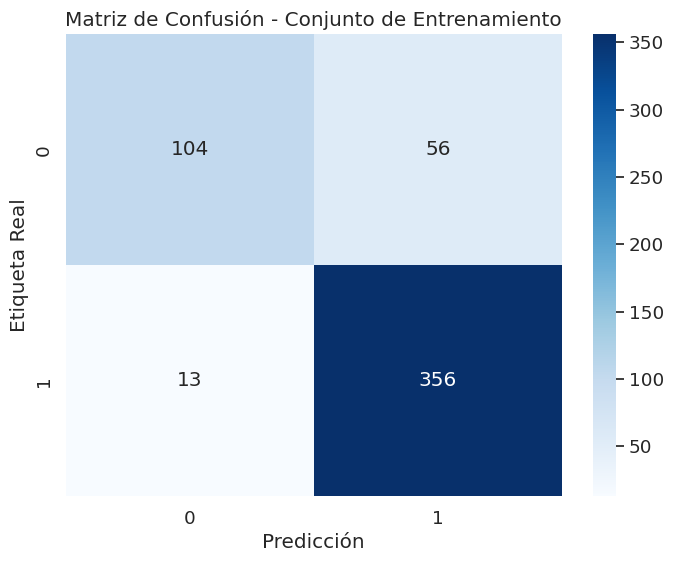

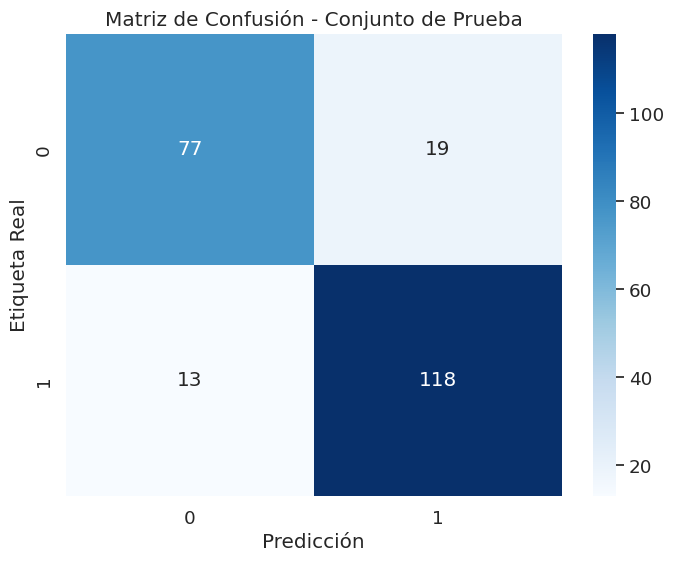

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
# Función para graficar la matriz de confusión con título
def graficar_matriz_confusion(matriz_confusion, etiquetas_clases, tipo):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Tamaño de fuente
    sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues",
                xticklabels=etiquetas_clases, yticklabels=etiquetas_clases)
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.title(f'Matriz de Confusión - {tipo}')
    plt.show()

etiquetas_clases = [0, 1]


# Graficar la matriz de confusión para el conjunto de entrenamiento
graficar_matriz_confusion(matriz_confusion_entrenamiento, etiquetas_clases, 'Conjunto de Entrenamiento')

# Graficar la matriz de confusión para el conjunto de prueba
graficar_matriz_confusion(matriz_confusion_prueba, etiquetas_clases, 'Conjunto de Prueba')

# Calculo de metricas

In [95]:


# Función para calcular métricas de evaluación
def calcular_metricas(matriz_confusion):
    TP = matriz_confusion[1, 1]
    FP = matriz_confusion[0, 1]
    FN = matriz_confusion[1, 0]
    TN = matriz_confusion[0, 0]
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    tasa_verdaderos_positivos = TP / (TP + FN)
    tasa_falsos_positivos = FP / (FP + TN)
    f1_score = 2 * (precision * tasa_verdaderos_positivos) / (precision + tasa_verdaderos_positivos)
    
    return accuracy, precision, tasa_verdaderos_positivos, tasa_falsos_positivos, f1_score


# Calcular métricas para el conjunto de entrenamiento
accuracy_entrenamiento, precision_entrenamiento, tasa_vp_entrenamiento, tasa_fp_entrenamiento, f1_score_entrenamiento = calcular_metricas(matriz_confusion_entrenamiento)

# Imprimir las métricas
print("Métricas de Evaluación para el Conjunto de Entrenamiento:")
print(f"Accuracy: {accuracy_entrenamiento:.4f}")
print(f"Precision: {precision_entrenamiento:.4f}")
print(f"Tasa de Verdaderos Positivos: {tasa_vp_entrenamiento:.4f}")
print(f"Tasa de Falsos Positivos: {tasa_fp_entrenamiento:.4f}")
print(f"F1-Score: {f1_score_entrenamiento:.4f}")
print()


# Calcular métricas para el conjunto de prueba
accuracy_prueba, precision_prueba, tasa_vp_prueba, tasa_fp_prueba, f1_score_prueba = calcular_metricas(matriz_confusion_prueba)

# Imprimir las métricas
print("Métricas de Evaluación para el Conjunto de Prueba:")
print(f"Accuracy: {accuracy_prueba:.4f}")
print(f"Precision: {precision_prueba:.4f}")
print(f"Tasa de Verdaderos Positivos: {tasa_vp_prueba:.4f}")
print(f"Tasa de Falsos Positivos: {tasa_fp_prueba:.4f}")
print(f"F1-Score: {f1_score_prueba:.4f}")



Métricas de Evaluación para el Conjunto de Entrenamiento:
Accuracy: 0.8696
Precision: 0.8641
Tasa de Verdaderos Positivos: 0.9648
Tasa de Falsos Positivos: 0.3500
F1-Score: 0.9117

Métricas de Evaluación para el Conjunto de Prueba:
Accuracy: 0.8590
Precision: 0.8613
Tasa de Verdaderos Positivos: 0.9008
Tasa de Falsos Positivos: 0.1979
F1-Score: 0.8806


In [96]:
print(len(prestamos))

756


Escojemos 5 grupos de datos con repeticion con 300 elementos cada uno

In [97]:
arboles = []
for i in range(5):
    datos = datos_entrenamiento.sample(n=300,replace=True)
    mejor_atributo = buscar_mayor_ganancia(datos,target_atributo)
    arbolForest = generar_subarbol(datos, target_atributo, mejor_atributo, atributos_restantes=2)
    arboles.append(arbolForest)

# PREDECIMOS CON NUESTROS 5 ARBOLES

In [98]:
import statistics

def predict_forest(arboles, instancia):
    resultados = []
    for a in arboles:
        resultados.append(predict(a,instancia))
    
    return statistics.mode(resultados)

# Matriz de confusion FOREST

In [99]:
# Función para calcular y mostrar la matriz de confusión
def calcular_matriz_confusion_forest(arboles, datos):
    y_true = datos["Creditability"]  # Etiquetas reales
    y_pred = [predict_forest(arboles,row) for _, row in datos.iterrows()]  # Etiquetas predichas por el clasificador
    matriz_confusion = confusion_matrix(y_true, y_pred)
    return matriz_confusion

# Calcular la matriz de confusión para el conjunto de entrenamiento
matriz_confusion_entrenamiento = calcular_matriz_confusion_forest(arboles, datos_entrenamiento)
print("Matriz de Confusión - Conjunto de Entrenamiento:")
print(matriz_confusion_entrenamiento)

# Calcular la matriz de confusión para el conjunto de prueba
matriz_confusion_prueba = calcular_matriz_confusion_forest(arboles, datos_prueba)
print("\nMatriz de Confusión - Conjunto de Prueba:")
print(matriz_confusion_prueba)

Matriz de Confusión - Conjunto de Entrenamiento:
[[100  60]
 [ 46 323]]

Matriz de Confusión - Conjunto de Prueba:
[[79 17]
 [74 57]]


# Graficar matriz de confusion FOREST

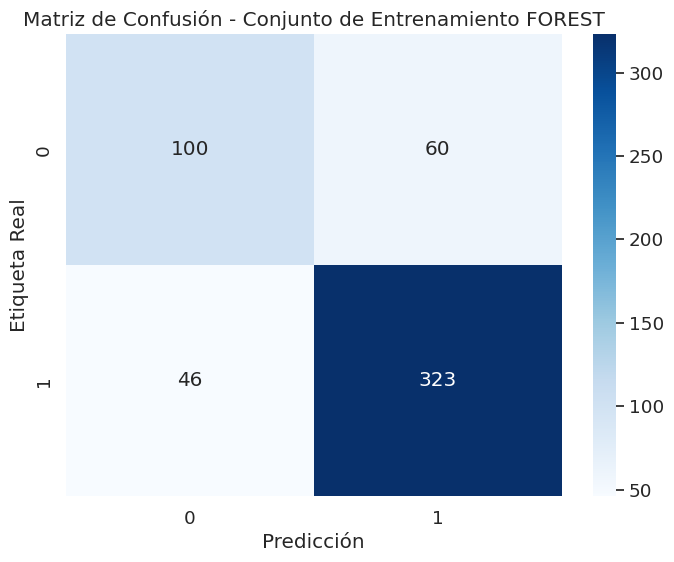

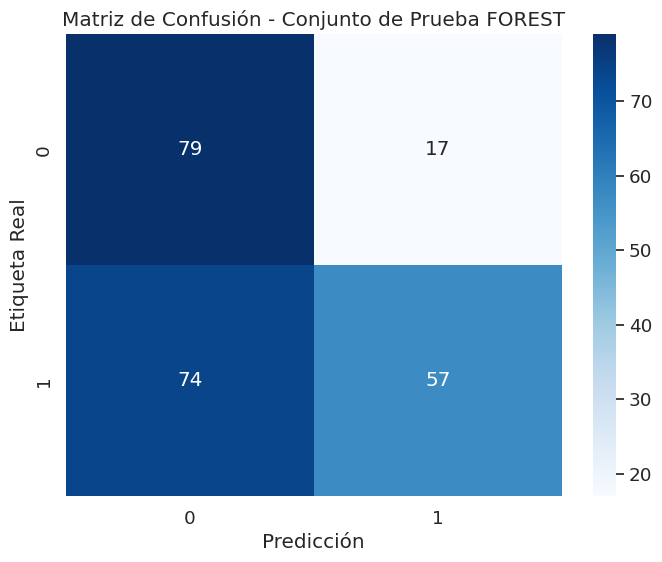

In [100]:
# Graficar la matriz de confusión para el conjunto de entrenamiento
graficar_matriz_confusion(matriz_confusion_entrenamiento, etiquetas_clases, 'Conjunto de Entrenamiento FOREST')

# Graficar la matriz de confusión para el conjunto de prueba
graficar_matriz_confusion(matriz_confusion_prueba, etiquetas_clases, 'Conjunto de Prueba FOREST')

# Calculo de metricas FOREST

In [101]:
# Calcular métricas para el conjunto de entrenamiento
accuracy_entrenamiento, precision_entrenamiento, tasa_vp_entrenamiento, tasa_fp_entrenamiento, f1_score_entrenamiento = calcular_metricas(matriz_confusion_entrenamiento)

# Imprimir las métricas
print("Métricas de Evaluación para el Conjunto de Entrenamiento FOREST:")
print(f"Accuracy: {accuracy_entrenamiento:.4f}")
print(f"Precision: {precision_entrenamiento:.4f}")
print(f"Tasa de Verdaderos Positivos: {tasa_vp_entrenamiento:.4f}")
print(f"Tasa de Falsos Positivos: {tasa_fp_entrenamiento:.4f}")
print(f"F1-Score: {f1_score_entrenamiento:.4f}")
print()


# Calcular métricas para el conjunto de prueba
accuracy_prueba, precision_prueba, tasa_vp_prueba, tasa_fp_prueba, f1_score_prueba = calcular_metricas(matriz_confusion_prueba)

# Imprimir las métricas
print("Métricas de Evaluación para el Conjunto de Prueba FOREST:")
print(f"Accuracy: {accuracy_prueba:.4f}")
print(f"Precision: {precision_prueba:.4f}")
print(f"Tasa de Verdaderos Positivos: {tasa_vp_prueba:.4f}")
print(f"Tasa de Falsos Positivos: {tasa_fp_prueba:.4f}")
print(f"F1-Score: {f1_score_prueba:.4f}")

Métricas de Evaluación para el Conjunto de Entrenamiento FOREST:
Accuracy: 0.7996
Precision: 0.8433
Tasa de Verdaderos Positivos: 0.8753
Tasa de Falsos Positivos: 0.3750
F1-Score: 0.8590

Métricas de Evaluación para el Conjunto de Prueba FOREST:
Accuracy: 0.5991
Precision: 0.7703
Tasa de Verdaderos Positivos: 0.4351
Tasa de Falsos Positivos: 0.1771
F1-Score: 0.5561


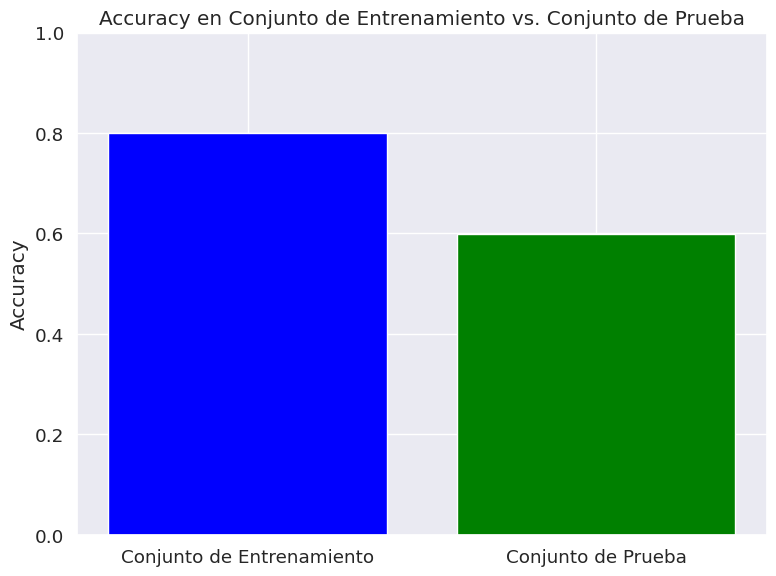

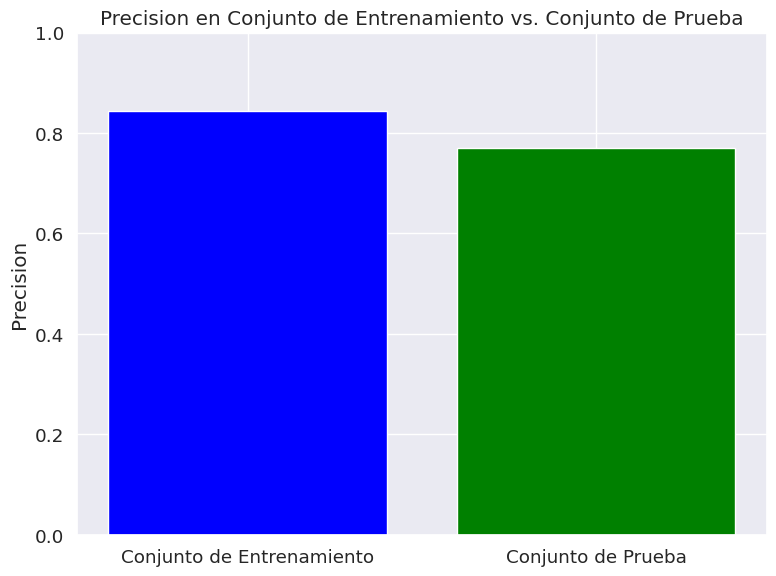

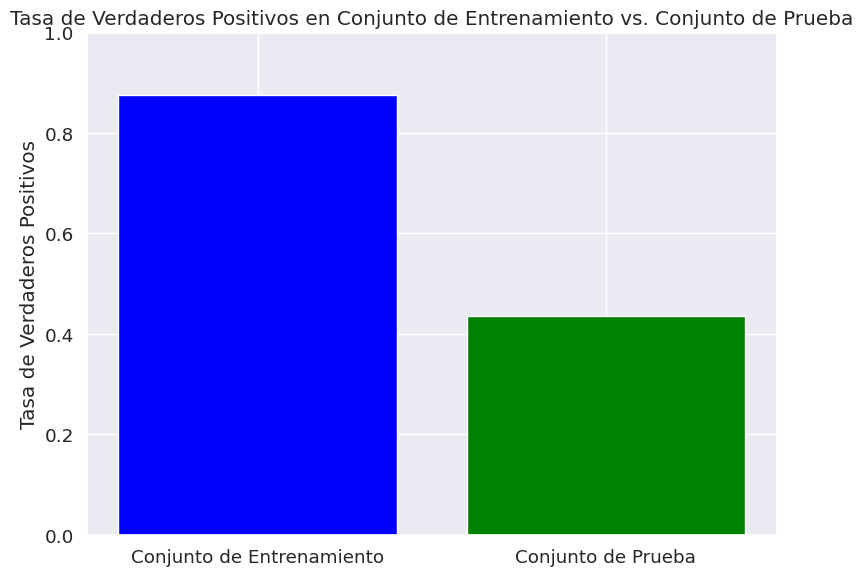

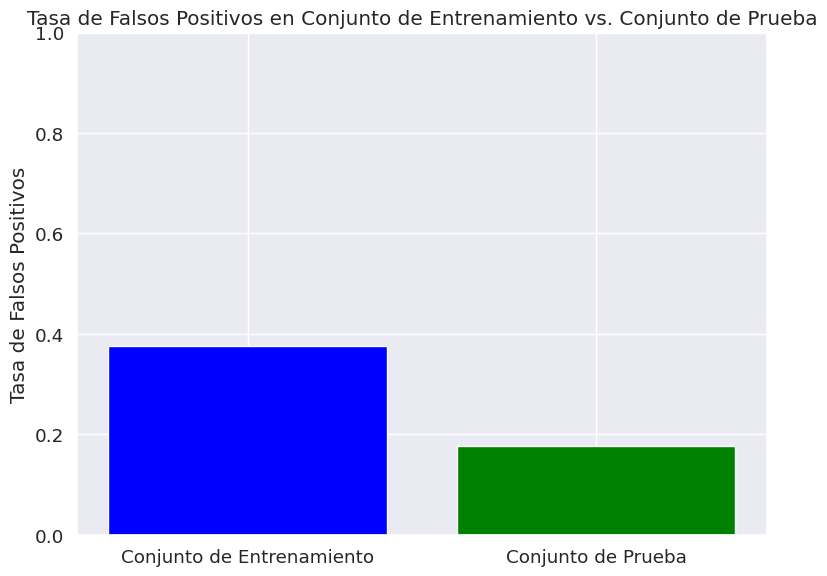

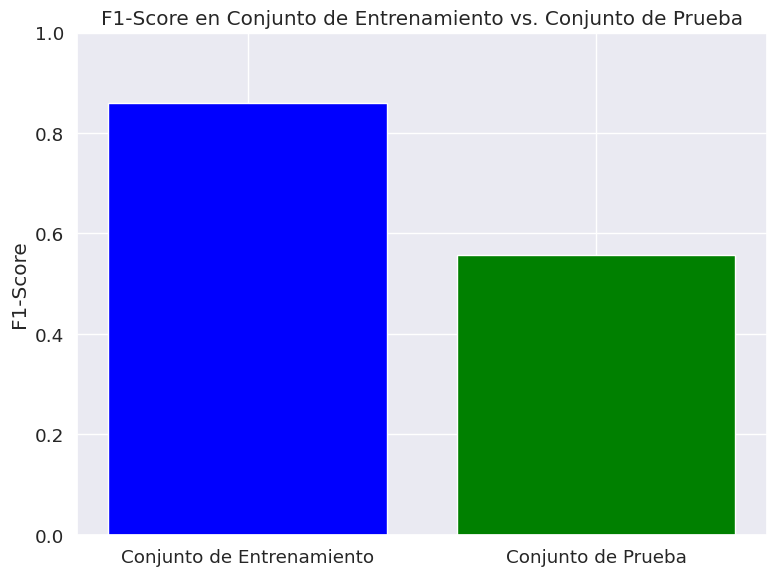

In [102]:
# Define las métricas y los nombres de los conjuntos
metricas = ["Accuracy", "Precision", "Tasa de Verdaderos Positivos", "Tasa de Falsos Positivos", "F1-Score"]
conjuntos = ["Conjunto de Entrenamiento", "Conjunto de Prueba"]

# Define los valores de las métricas
valores = [
    [accuracy_entrenamiento, precision_entrenamiento, tasa_vp_entrenamiento, tasa_fp_entrenamiento, f1_score_entrenamiento],
    [accuracy_prueba, precision_prueba, tasa_vp_prueba, tasa_fp_prueba, f1_score_prueba]
]

# Crea un gráfico de barras para cada métrica
for i, metrica in enumerate(metricas):
    plt.figure(figsize=(8, 6))
    plt.bar(conjuntos, [valores[0][i], valores[1][i]], color=['blue', 'green'])
    plt.title(f"{metrica} en Conjunto de Entrenamiento vs. Conjunto de Prueba")
    plt.ylabel(metrica)
    plt.ylim(0, 1)  # Ajusta el rango del eje y entre 0 y 1 para métricas de porcentaje
    plt.tight_layout()
    plt.show()